# Logistic Regression with a Neural Network mindset

- Build a logistic regression classifier to recognize cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

## 1. What we'll learn:
- Initializing parameters
- Calculating the cost function and its gradient
- Using an optimization algorithm (gradient descent)



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#2 Problem Set

***Problem Statement***: You are given a dataset ("data.h5") containing:
- a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

- We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [8]:
# Loading the data (cat/non-cat)
import h5py
import scipy
from PIL import Image
from scipy import ndimage

100%|██████████| 2.66M/2.66M [00:00<00:00, 3.08MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sagar2522/cat-vs-non-cat/versions/1


In [14]:
# Install kagglehub if not already installed
!pip install kagglehub

import kagglehub
import os
import shutil

# Create the target directory if it doesn't exist
target_dir = "/content/data"
os.makedirs(target_dir, exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("sagar2522/cat-vs-non-cat")

# Print the path to the downloaded dataset
print("Path to downloaded dataset:", path)

# Copy all files to /content/data
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        src_path = os.path.join(dirname, filename)
        dst_path = os.path.join(target_dir, filename)
        shutil.copy(src_path, dst_path)

# List all files in /content/data to confirm
print("\nFiles in /content/data:")
for file in os.listdir(target_dir):
    print(os.path.join(target_dir, file))


Path to downloaded dataset: /kaggle/input/cat-vs-non-cat

Files in /content/data:
/content/data/test_catvsnoncat.h5
/content/data/.ipynb_checkpoints
/content/data/train_catvsnoncat.h5


Files in /content/data:
/content/data/test_catvsnoncat.h5
/content/data/.ipynb_checkpoints
/content/data/train_catvsnoncat.h5

Exploring /content/data/train_catvsnoncat.h5:
Keys in file: ['list_classes', 'train_set_x', 'train_set_y']
 - list_classes: shape=(2,), dtype=|S7
 - train_set_x: shape=(209, 64, 64, 3), dtype=uint8
 - train_set_y: shape=(209,), dtype=int64

Exploring /content/data/test_catvsnoncat.h5:
Keys in file: ['list_classes', 'test_set_x', 'test_set_y']
 - list_classes: shape=(2,), dtype=|S7
 - test_set_x: shape=(50, 64, 64, 3), dtype=uint8
 - test_set_y: shape=(50,), dtype=int64


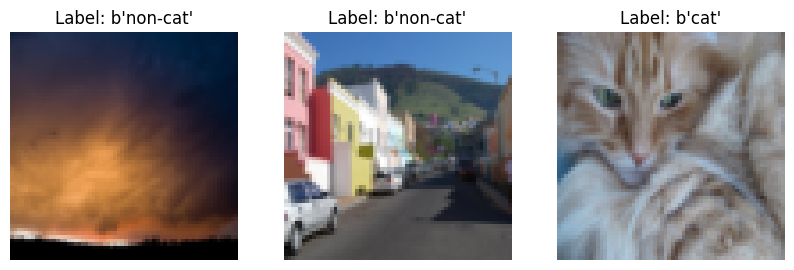

In [16]:
# Install required libraries
!pip install h5py  # For reading HDF5 files

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Define the data directory
data_dir = "/content/data"

# Verify files in /content/data
print("Files in /content/data:")
for file in os.listdir(data_dir):
  print(os.path.join(data_dir, file))

# Function to explore HDF5 file contents
def explore_h5_file(file_path):
  print(f"\nExploring {file_path}:")
  with h5py.File(file_path, 'r') as f:
    # List all keys in the HDF5 file
    print("Keys in file:", list(f.keys()))
    # Print details for each key
    for key in f.keys():
      data = f[key]
      print(f" - {key}: shape={data.shape}, dtype={data.dtype}")

# Paths to the two files
train_file = os.path.join(data_dir, "train_catvsnoncat.h5")
test_file = os.path.join(data_dir, "test_catvsnoncat.h5")

# Explore both files
explore_h5_file(train_file)
explore_h5_file(test_file)

# Optional: Visualize a few images from the training set
def visualize_images(h5_file, dataset_key="train_set_x", label_key="train_set_y", num_images=3):
    with h5py.File(h5_file, 'r') as f:
      images = f[dataset_key][:]  # Load image data
      labels = f[label_key][:] if label_key in f else None  # Load labels if available
      class_names = f.get("list_classes")[:] if "list_classes" in f else None  # Load class names if available

      # Plot a few images
      plt.figure(figsize=(10, 4))
      for i in range(min(num_images, images.shape[0])):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        if labels is not None:
          label = labels[i]
          class_name = class_names[label] if class_names is not None else label
          plt.title(f"Label: {class_name}")
          plt.axis('off')
      plt.show()

# Visualize a few training images (adjust dataset_key and label_key based on file contents)
visualize_images(train_file, dataset_key="train_set_x", label_key="train_set_y")

## 2. Data Processing

1. train_set_x (or similar): Training images *(shape: (m_train, height, width, channels))*.
2. train_set_y: Training labels *(shape: (m_train,) or (1, m_train)).*
3. test_set_x (or similar): *Test images (shape: (m_test, height, width, channels))*.
4. test_set_y: *Test labels (shape: (m_test,) or (1, m_test)).*


In [17]:
data_dir = "/content/data"
train_file = f"{data_dir}/train_catvsnoncat.h5"
test_file = f"{data_dir}/test_catvsnoncat.h5"

with h5py.File(train_file, 'r') as f:
  train_set_x_orig = np.array(f["train_set_x"][:])  # Load training images
  train_set_y = np.array(f["train_set_y"][:])       # Load training labels

# Load the testing dataset
with h5py.File(test_file, 'r') as f:
  test_set_x_orig = np.array(f["test_set_x"][:])    # Load testing images
  test_set_y = np.array(f["test_set_y"][:])         # Load testing labels

# Extract dimensions
m_train = train_set_x_orig.shape[0]  # Number of training examples
m_test = test_set_x_orig.shape[0]    # Number of testing examples
num_px = train_set_x_orig.shape[1]   # Height/Width of each image (assuming square)

# Print the required information
print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px * num_px * 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise**: Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px *
 num_px *
 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b *
c * d, a) is to use:



```
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```



In [18]:
train_set_x_orig.shape[0]

209

In [22]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T


print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (209,)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (50,)
sanity check after reshaping: [17 31 56 22 33]


To represent color images, **the red, green and blue channels (RGB)** must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

- One common preprocessing step in machine learning is to **center and standardize your dataset**, meaning that you ***substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array.*** But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

Let's standardize our dataset:

In [23]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.



> **What you need to remember:**
Common steps for pre-processing a new dataset are:


> Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
Reshape the datasets such that each example is now a vector of size (num_px * num_px * 3, 1)
"Standardize" the data



# 3. General Architecture of the learning algorithm

- It's time to design a simple algorithm to distinguish cat images from non-cat images.
- You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!

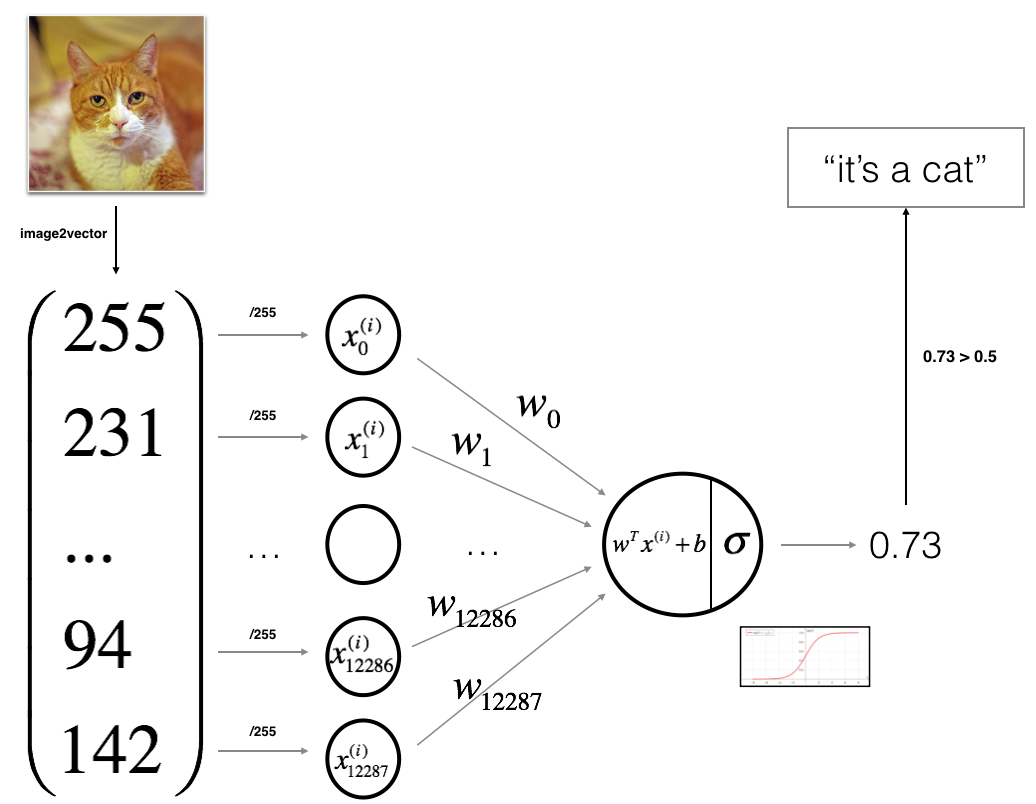

Mathematical expression of the algorithm:

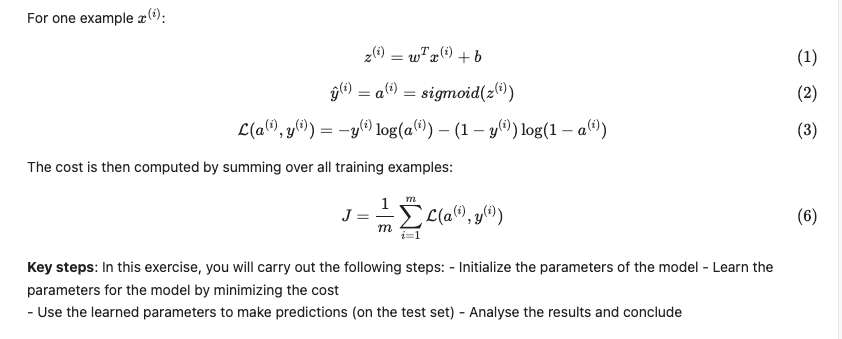

## 4 - Building the parts of our algorithm

The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
  - Calculate current loss (forward propagation)
  - Calculate current gradient (backward propagation)
  - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model().`

### 4.1 - Helper functions

In [25]:
def sigmoid(z):
  """
  Compute the sigmoid of z

  Arguments:
  z -- A scalar or numpy array of any size.

  Return:
  s -- sigmoid(z)
  """

  s = 1 / (1 + np.exp(-z))

  return s

print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 - Initializing parameters
- Exercise: Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [26]:
def initialize_with_zeros(dim):
  """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
  """

  w = np.zeros((dim, 1))
  b = 0

  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))

  return w, b

In [29]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w shape = " + str(w.shape))
print ("b = " + str(b))

w shape = (2, 1)
b = 0


### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise**: Implement a function propagate() that computes the cost function and its gradient.

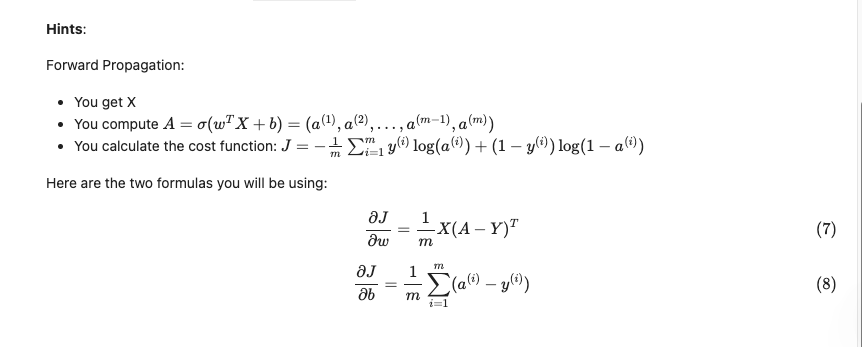

In [33]:
def propagate(w, b, X, Y):
  """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
  """

  m = X.shape[1]

  # FORWARD PROPAGATION (FROM X TO COST)
  Z = np.dot(w.T, X) + b
  A = sigmoid(Z) # compute activation
  cost = -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

  # BACKWARD PROPAGATION (TO FIND GRAD)

  dw = (1 / m) * np.dot(X, (A - Y).T)
  db = (1 / m) * np.sum(A - Y)

  assert(dw.shape == w.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape == ())

  grads = {"dw": dw,
          "db": db}
  return grads, cost

In [34]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - Optimization
You have initialized your parameters.
You are also able to compute a cost function and its gradient.
Now, you want to update the parameters using gradient descent.
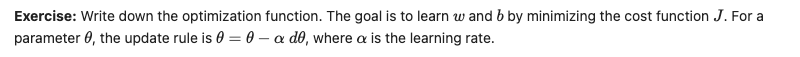

In [35]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
  """
  costs = []

  for i in range(num_iterations):

    grads, cost = propagate(w, b, X, Y)

    dw = grads["dw"]
    db = grads["db"]

    w = w - learning_rate * dw
    b = b - learning_rate * db

    # Record the costs
    if i % 100 == 0:
      costs.append(cost)

    # Print the cost every 100 training iterations
    if print_cost and i % 100 == 0:
      print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

  return params, grads, costs


In [37]:
w, b

(array([[1.],
        [2.]]),
 2.0)

In [36]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


Exercise: The previous function will output the learned `w and b`. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

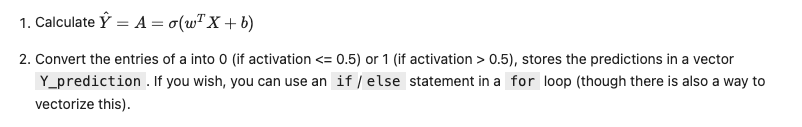

In [38]:
def predict(w, b, X):
  '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
  '''

  m = X.shape[1]
  Y_prediction = np.zeros((1,m))

  A = sigmoid(np.dot(w.T, X) + b)

  for i in range(A.shape[1]):
    # Convert probabilities A[0,i] to actual predictions p[0,i]
    Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

  assert(Y_prediction.shape == (1, m))

  return Y_prediction


In [39]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**What to remember:** You've implemented several functions that: - Initialize (w,b) - Optimize the loss iteratively to learn parameters (w,b): - computing the cost and its gradient - updating the parameters using gradient descent - Use the learned (w,b) to predict the labels for a given set of examples

### 5 - Merge all functions into a model


You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise**: Implement the model function. Use the following notation: - Y_prediction_test for your predictions on the test set - Y_prediction_train for your predictions on the train set - w, costs, grads for the outputs of optimize()

In [42]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
  """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
  """

  # initialize parameters with zeros

  w, b = initialize_with_zeros(X_train.shape[0])

  # Gradient descent
  parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

  # Retrieve parameters w and b from dictionary "parameters"
  w = parameters["w"]
  b = parameters["b"]

  # Predict test/train set examples
  Y_prediction_test = predict(w, b, X_test)
  Y_prediction_train = predict(w, b, X_train)

  # Print train/test Errors
  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


  d = {"costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train" : Y_prediction_train,
        "w" : w,
        "b" : b,
        "learning_rate" : learning_rate,
        "num_iterations": num_iterations}

  return d



In [43]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


Comment: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the index variable) you can look at predictions on pictures of the test set.

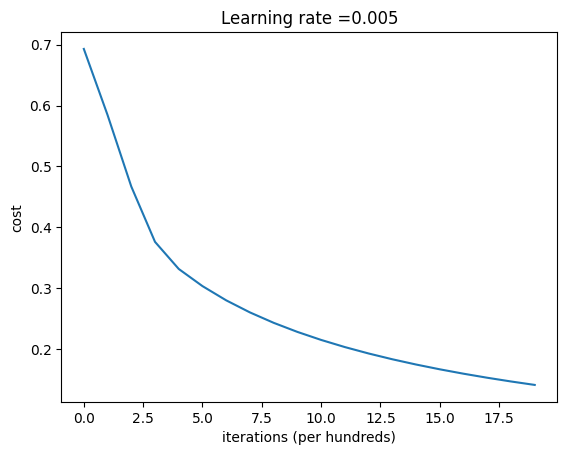

In [47]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Interpretation: You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.

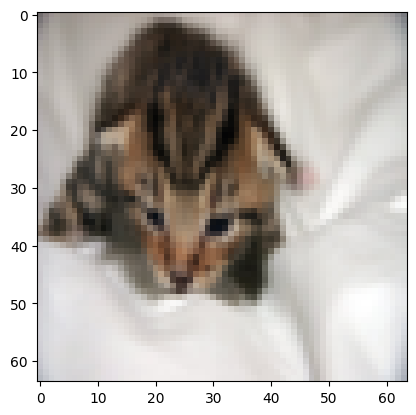

In [46]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))

###6 - Further analysis

Choice of learning rate
Reminder: In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate
 determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the learning_rates variable to contain, and see what happens.

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



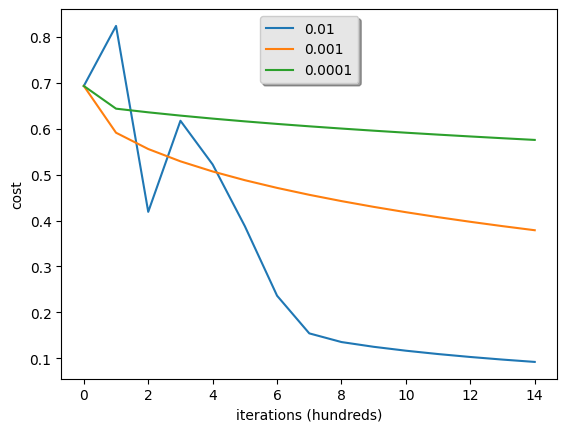

In [50]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

Interpretation:

- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you:
  - Choose the learning rate that better minimizes the cost function.
  - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.)

###7 - Test with your own image

In [51]:
## START CODE HERE ## (PUT YOUR IMAGE NAME)
my_image = "my_image.jpg"   # change this to the name of your image file
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: module 'scipy.ndimage' has no attribute 'imread'

**What to remember from this assignment:** 1. Preprocessing the dataset is important. 2. You implemented each function separately: initialize(), propagate(), optimize(). Then you built a model(). 3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!